# Set Up
A vehicle can travel freely in any direction. For example, a robot with mecanum wheels. It starts out at $(x, y) = (5, 5)$. The workspace is limited to a square region from zero to thirty in both $x$ and $y$. The following obstacles are in the workspace:
\begin{itemize}
\item A polygon with vertices: [(8, 6), (10, 7), (10, 10), (6, 10), (6, 9)]
\item A triangle with vertices: [(5, 15), (8, 12), (10, 15)]
\item A circle centered at (15, 8) with a radius of 2
\end{itemize}

In [1]:
import math
import random
from time import sleep
import descartes as dc
from Dubins import Dubins
from IPython import display
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import LineString

%matplotlib inline
show_animation = True
plt.rcParams['figure.figsize'] = [10, 10]
# random.seed(7)

obstacleList = [
    Point((15, 8)).buffer(2),
    Polygon([(5, 15), (8, 12), (10, 15)]),
    Polygon([(8, 6), (10, 7), (10, 10), (6, 10), (6, 9)]),
]

\pagebreak
# RRT Algorithm
This is just a simple RRT algorithm that searches with only one tree from start to goal. If $q_{new}$ has a path to $q_{goal}$ and the path length is less than some threshold then the tree will add $q_{goal}$ and complete the algorithm.

In [2]:
class RRT:
    def __init__(self, start, goal, obstacle_list, play_area=None, rand_area=None, dubins=False, k=0.5):
        self.start = self.Node(start[0], start[1], start[2])
        self.end = self.Node(goal[0], goal[1], goal[2])
        self.obstacle_list = obstacle_list

        if play_area is not None:
            self.play_area = LineString([
                (play_area[0], play_area[0]),
                (play_area[0], play_area[1]),
                (play_area[1], play_area[1]),
                (play_area[1], play_area[0]),
                (play_area[0], play_area[0]),
            ])
        else:
            self.play_area = None

        if rand_area is not None:
            self.rand_area = rand_area
        else:
            self.rand_area = play_area

        self.dubins = dubins
        self.k = k
        self.node_list = []

    class Node:
        def __init__(self, x, y, a=None):
            self.x = x
            self.y = y
            self.a = a
            self.path = None
            self.parent = None

    def planning(self, animation=True):
        self.node_list = [self.start]
        for i in range(500):
            rnd_node = self.Node(random.uniform(self.rand_area[0], self.rand_area[1]),
                                 random.uniform(self.rand_area[0], self.rand_area[1]),
                                 random.uniform(0, 2 * math.pi))

            dlist = []
            if self.dubins:
                for n in self.node_list:
                    paths, _ = Dubins((n.x, n.y), (rnd_node.x, rnd_node.y), 1/self.k, n.a, rnd_node.a).getPaths()
                    dlist.append(paths[0].length)
            else:
                dlist = [(n.x - rnd_node.x) ** 2 + (n.y - rnd_node.y) ** 2 for n in self.node_list]
            nearest_node = self.node_list[dlist.index(min(dlist))]

            new_node = self.steer(nearest_node, rnd_node)
            if self.check_collision(new_node):
                self.node_list.append(new_node)

            last_node = self.node_list[-1]
            c = 2
            if self.dubins:
                c = 6
            if self.calc_dist_to_goal(last_node.x, last_node.y, last_node.a) <= c:
                self.final_steer(last_node)
                if self.check_collision(self.end):
                    self.node_list.append(self.end)
                    return self.generate_final_course(len(self.node_list) - 1)

            if animation and i % 1 == 0:
                self.draw_graph(rnd_node)

        return None

    def steer(self, from_node, to_node):
        new_node = self.Node((1 * from_node.x + 3 * to_node.x) / 4,
                             (1 * from_node.y + 3 * to_node.y) / 4)
        new_node.parent = from_node

        start = (from_node.x, from_node.y)
        goal = (new_node.x, new_node.y)
        if self.dubins:
            paths, new_node.a = Dubins(start, goal, 1/self.k, from_node.a).getPaths()
        else:
            paths = [LineString([(start[0], start[1]), (goal[0], goal[1])])]

        for i in range(len(paths)):
            new_node.path = paths[i]
            if self.check_collision(new_node):
                break

        return new_node

    def final_steer(self, from_node):
        self.end.parent = from_node

        start = (from_node.x, from_node.y)
        goal = (self.end.x, self.end.y)
        if self.dubins:
            paths, _ = Dubins(start, goal, 1/self.k, from_node.a, self.end.a).getPaths()
        else:
            paths = [LineString([(start[0], start[1]), (goal[0], goal[1])])]

        for i in range(len(paths)):
            self.end.path = paths[i]
            if self.check_collision(self.end):
                break

    def check_collision(self, node):
        if node is None:
            return False

        for ob in self.obstacle_list:
            if node.path.intersects(ob):
                return False

        if self.play_area is None:
            return True

        return not node.path.intersects(self.play_area)

    def calc_dist_to_goal(self, x, y, a):
        if self.dubins:
            paths, _ = Dubins((x, y), (self.end.x, self.end.y), 1/self.k, a, self.end.a).getPaths()
            return paths[0].length

        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    def generate_final_course(self, goal_ind):
        path = []
        node = self.node_list[goal_ind]
        while node.parent is not None:
            x, y = node.path.xy
            path.extend(zip(x[::-1], y[::-1]))
            node = node.parent

        return LineString(path)

    def draw_graph(self, rnd=None):
        plt.clf()
        plt.gcf().canvas.mpl_connect(
            'key_release_event', lambda event: [exit(0) if event.key == 'escape' else None])

        for node in self.node_list:
            if node.parent:
                plt.plot(*node.path.xy, "-g")

        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")

        for node in self.node_list:
            if node.parent:
                plt.plot(node.x, node.y, "xr")

        if self.dubins:
            plt.gca().quiver(self.start.x, self.start.y, math.cos(self.start.a),
                             math.sin(self.start.a), scale=25, minshaft=2)
            plt.gca().quiver(self.end.x, self.end.y, math.cos(self.end.a),
                             math.sin(self.end.a), scale=25, minshaft=2)
        else:
            plt.plot(self.start.x, self.start.y, "xg")
            plt.plot(self.end.x, self.end.y, "xb")

        if self.play_area is not None:
            plt.plot(*self.play_area.xy, "-k")

        for ob in self.obstacle_list:
            plt.gca().add_patch(dc.PolygonPatch(ob))
        
        plt.axis("equal")
        display.display(plt.gcf())
        display.clear_output(wait=True)
        sleep(0.01)

\pagebreak
# Problem 1
Use an RRT to plan a path from the starting point to $(15, 15)$, making sure to avoid the obstacles.

The distance heuristic is simply the Euclidean distance, and $q_{new}$ is 75% of the way between $q_{near}$ and $q_{rand}$.

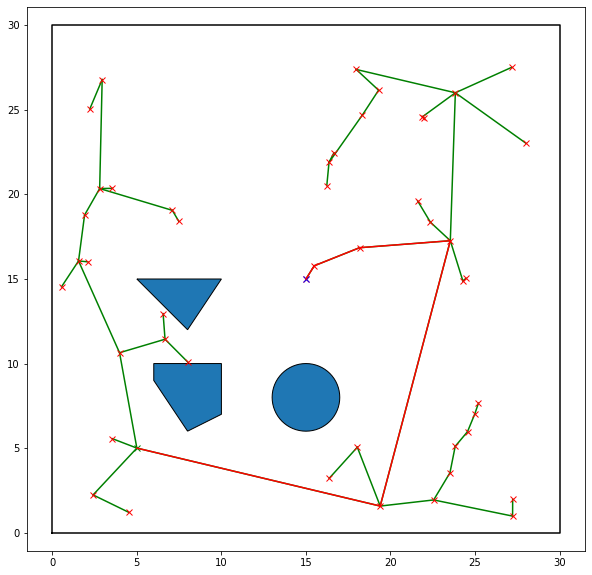

In [3]:
rrt = RRT(
    start=[5, 5, None],
    goal=[15, 15, None],
    obstacle_list=obstacleList,
    play_area=[0, 30]
)
path = rrt.planning(animation=show_animation)

if path is None:
    print("Cannot find path")
else:
    print("Path found")
    rrt.draw_graph()
    plt.plot(*path.xy, '-r')
    plt.axis("equal")
    display.display(plt.gcf())
    display.clear_output(wait=True)

\pagebreak
# Problem 2
Repeat Problem 1 with a vehicle that can only drive forward at 1-m/s on a path with a constrained curvature, $−0.5 \le \kappa \le 0.5$ rad/m. Because the orientation of the vehicle matters now, your starting configuration is $(x, y, \theta) = (5, 5, \pi/4)$ and your goal configuration is $(15, 15, \pi/2)$.

We also know that the radius of the curve being driven is $r = 1/\kappa$

q<sub>new</sub> is 75% of the way between $q_{near}$ and $q_{rand}$. The distance hueristic uses Dubins to finds 2-4 possible paths between $q_{near}$ and $q_{new}$ and picks the shortest one. While a bit expensive, this accurately solves the problem of factoring in orientation into the distance hueristic.

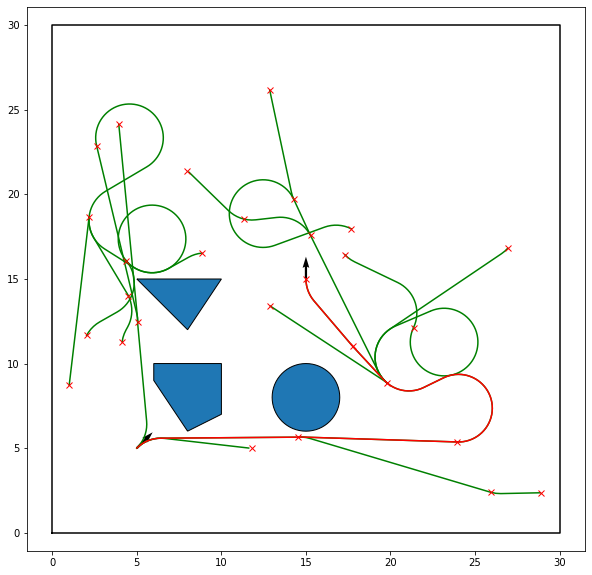

In [4]:
rrt = RRT(
    start=[5, 5, math.pi / 4],
    goal=[15, 15, math.pi / 2],
    obstacle_list=obstacleList,
    play_area=[0, 30],
    dubins=True,
    k = 0.5
)
path = rrt.planning(animation=show_animation)

if path is None:
    print("Cannot find path")
else:
    print("Path found")
    rrt.draw_graph()
    plt.plot(*path.xy, '-r')
    plt.axis("equal")
    display.display(plt.gcf())
    display.clear_output(wait=True)